In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import time

from numpy.ctypeslib import ndpointer
import ctypes

import warnings
warnings.filterwarnings('ignore')

In [2]:
tickers = ['BTC', 'ETH', 'XRP', 'DOGE','ETC']
path = './data/'+tickers[0]+'-M.csv'
df = pd.read_csv(path,parse_dates=[0], index_col=[0])
df.drop('value',axis=1, inplace=True)
df.head(3)

,open,high,low,close,volume
2018-09-19 23:50:00,7180000.0,7187000.0,7180000.0,7187000.0,0.504830
2018-09-19 23:51:00,7186000.0,7188000.0,7181000.0,7181000.0,0.882076
2018-09-19 23:52:00,7184000.0,7188000.0,7183000.0,7188000.0,0.486359


In [3]:
from pymodule.dllMod import pred_per
pred = pred_per(df, 0.05)

In [4]:
from pymodule.dataMod import OHLCDataset

seq_length = 70

dataset = OHLCDataset(df[10:-4], pred[10:-4], 50)

In [5]:
from torch.utils.data import DataLoader, random_split

test_size = 262144
train_set, test_set = random_split(dataset, [len(dataset) - test_size, test_size])
print(f'train dataset length : {len(train_set)}')
print(f'test dataset length : {len(test_set)}')

train_dloader = DataLoader(train_set, batch_size=512, shuffle=True, drop_last=True)
test_dloader = DataLoader(test_set, batch_size=128, shuffle=True, drop_last=True)

train dataset length : 1553814
test dataset length : 262144


In [6]:
train_features, train_labels = next(iter(train_dloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([512, 4, 50, 5])
Labels batch shape: torch.Size([512, 1])


In [7]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class OLNN(nn.Module):
    def __init__(self):
        super(OLNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=8, kernel_size=10)
        self.conv2 = nn.Conv1d(in_channels=5, out_channels=8, kernel_size=10)
        self.conv3 = nn.Conv1d(in_channels=5, out_channels=8, kernel_size=10)
        self.conv4 = nn.Conv1d(in_channels=5, out_channels=8, kernel_size=10)
        
        self.conv5 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=5)
        self.conv6 = nn.Conv1d(in_channels=16, out_channels=4,kernel_size=4)
        self.conv7 = nn.Conv1d(in_channels=4, out_channels=2,kernel_size=2)
        
        self.fc1 = nn.Linear(66,64)
        self.fc2 = nn.Linear(64,8)
        self.fc3 = nn.Linear(8,1)
        
    def forward(self, x):
        x = x.permute((1,0,3,2))
        
        x1 = self.conv1(x[0])
        x2 = self.conv2(x[1])
        x3 = self.conv3(x[2])
        x4 = self.conv4(x[3])
        
        x = torch.cat((x1,x2,x3,x4),1)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        
        x = self.fc1(x.flatten(1))
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
model = OLNN().to(device)

In [9]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr = 0.0001)
criterion = nn.MSELoss()

def fit(epoch, model, data_loader, phase):
    if phase == 'train':
        model.train()
    if phase == 'valid':
        model.eval()
    
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        
        if phase == 'train':
            optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.permute(1,0), target.permute(1,0))
        running_loss += loss.item()
        
        if phase == 'train':
            loss.backward()
            optimizer.step()
        
    loss = running_loss / len(data_loader.dataset)
    
    print (f'epoch:{epoch}, {phase}loss is {loss}')
    return loss

In [10]:
path = "./OLNN.pt"
losses = []
val_losses = []
# model = torch.load(path).to(device)

In [11]:
start = time.time()
for epoch in range(60):
    epoch_loss = fit(epoch,model,train_dloader, phase = 'train')
    losses.append(epoch_loss)
    val_epoch_loss = fit(epoch, model, test_dloader, phase ='valid')
    val_losses.append(val_epoch_loss)
    print("{:0,.2f}분".format((time.time()-start)/60))
torch.save(model, path)

epoch:0, trainloss is 4.63664240813722e-06
epoch:0, validloss is 1.4381367894888974e-06
1.42분
epoch:1, trainloss is 9.969710863920386e-08
epoch:1, validloss is 8.281516606072764e-08
2.78분
epoch:2, trainloss is 1.773405758903989e-08
epoch:2, validloss is 5.966232869357956e-08
4.02분
epoch:3, trainloss is 1.634578927279166e-08
epoch:3, validloss is 5.91615241603196e-08
5.23분
epoch:4, trainloss is 1.631049521752932e-08
epoch:4, validloss is 5.913153202806096e-08
6.45분
epoch:5, trainloss is 1.630338217231496e-08
epoch:5, validloss is 5.912882422944889e-08
7.69분
epoch:6, trainloss is 1.6309110070764232e-08
epoch:6, validloss is 5.91281534090618e-08
8.95분
epoch:7, trainloss is 1.6308511528053485e-08
epoch:7, validloss is 5.912790930267739e-08
10.23분
epoch:8, trainloss is 1.6307387696156824e-08
epoch:8, validloss is 5.9128012530758854e-08
11.51분
epoch:9, trainloss is 1.630765813318136e-08
epoch:9, validloss is 5.912801026423421e-08
12.79분
epoch:10, trainloss is 1.630819998136669e-08
epoch:10, 

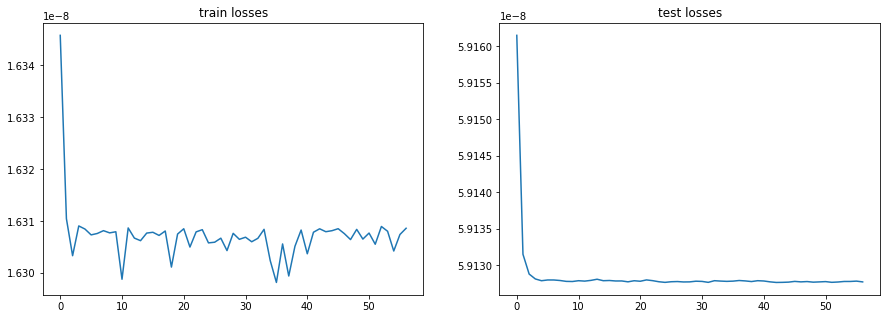

In [21]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(losses[3:])
ax[0].set_title('train losses')

ax[1].plot(val_losses[3:])
ax[1].set_title('test losses')
plt.show()